# Machine Learning - SS18


## THE SIMPSONS

In the following, we use "The Simpsons Character Data" provided by the user 'alexattia' on kaggle (source to the data: https://www.kaggle.com/alexattia/the-simpsons-characters-dataset/data) 

We provide a slighty preprocessed data, which will be used in the following. 

<b>Download Link</b> of the preprocessed data: 
+ Dataset: http://www.dbs.ifi.lmu.de/~frey/MLSS18/the_simpsons_char_dataset/dataset.h5
+ Labels: http://www.dbs.ifi.lmu.de/~frey/MLSS18/the_simpsons_char_dataset/labels.h5

Store the files in exactly the same folder as this notebook (Otherwise you can also adjust the paths in the following cells)

#### Character Data
First, we attach to each of the characters in the dataset a unique id which will be the class label for a specific char.

In [6]:
map_characters= {0: 'abraham_grampa_simpson',
                1: 'apu_nahasapeemapetilon',
                2: 'bart_simpson',
                3: 'charles_montgomery_burns',
                4: 'chief_wiggum',
                5: 'comic_book_guy',
                6: 'edna_krabappel',
                7: 'homer_simpson',
                8: 'kent_brockman',
                9: 'krusty_the_clown',
                10:'lisa_simpson',
                11:'marge_simpson',
                12:'milhouse_van_houten',
                13:'moe_szyslak',
                14:'ned_flanders',
                15:'nelson_muntz',
                16:'principal_skinner',
                17:'sideshow_bob'}
n_classes = len(map_characters)

#### Load data
In order to load the data, the library h5py has to be installed. If you haven't installed it yet, you can use the pip command :
+ pip install h5py

In [7]:
import h5py

def load_data():
    # in case the file is stored not in the same folder as this notebook, please adjust the path
    h5f = h5py.File('dataset.h5','r+')
    X_train = h5f['X_train'][:]
    X_test = h5f['X_test'][:]
    h5f.close()    

    # in case the file is stored not in the same folder as this notebook, please adjust the path
    h5f = h5py.File('labels.h5','r+')
    y_train = h5f['y_train'][:]
    y_test = h5f['y_test'][:]
    h5f.close()  
    
    X_train = X_train.astype('float32') / 255.
    X_test = X_test.astype('float32') / 255.

    return X_train, X_test, y_train, y_test

In [8]:
X_train, X_test, y_train, y_test = load_data()

In [9]:
print("Shape of images: ", X_train.shape)
print("-------")
print(X_train)
print(y_train)

Shape of images:  (14317, 64, 64, 3)
-------
[[[[0.41568628 0.6392157  0.4627451 ]
   [0.41568628 0.6392157  0.4627451 ]
   [0.41568628 0.6392157  0.4627451 ]
   ...
   [0.4117647  0.6509804  0.49019608]
   [0.4117647  0.6509804  0.49019608]
   [0.4117647  0.6509804  0.49019608]]

  [[0.41568628 0.6392157  0.4627451 ]
   [0.41568628 0.6392157  0.4627451 ]
   [0.41568628 0.6392157  0.4627451 ]
   ...
   [0.4117647  0.6509804  0.49019608]
   [0.4117647  0.6509804  0.49019608]
   [0.4117647  0.6509804  0.49019608]]

  [[0.4392157  0.62352943 0.48235294]
   [0.4392157  0.62352943 0.48235294]
   [0.4392157  0.62352943 0.48235294]
   ...
   [0.4117647  0.6509804  0.49019608]
   [0.4117647  0.6509804  0.49019608]
   [0.4117647  0.6509804  0.49019608]]

  ...

  [[0.5764706  0.05882353 0.01176471]
   [0.5764706  0.05882353 0.01176471]
   [0.5764706  0.05882353 0.01176471]
   ...
   [0.5764706  0.05882353 0.01176471]
   [0.5764706  0.05882353 0.01176471]
   [0.5764706  0.05882353 0.01176471]]



#### Visualization
Now, let's have a look at some random images for each class/character.

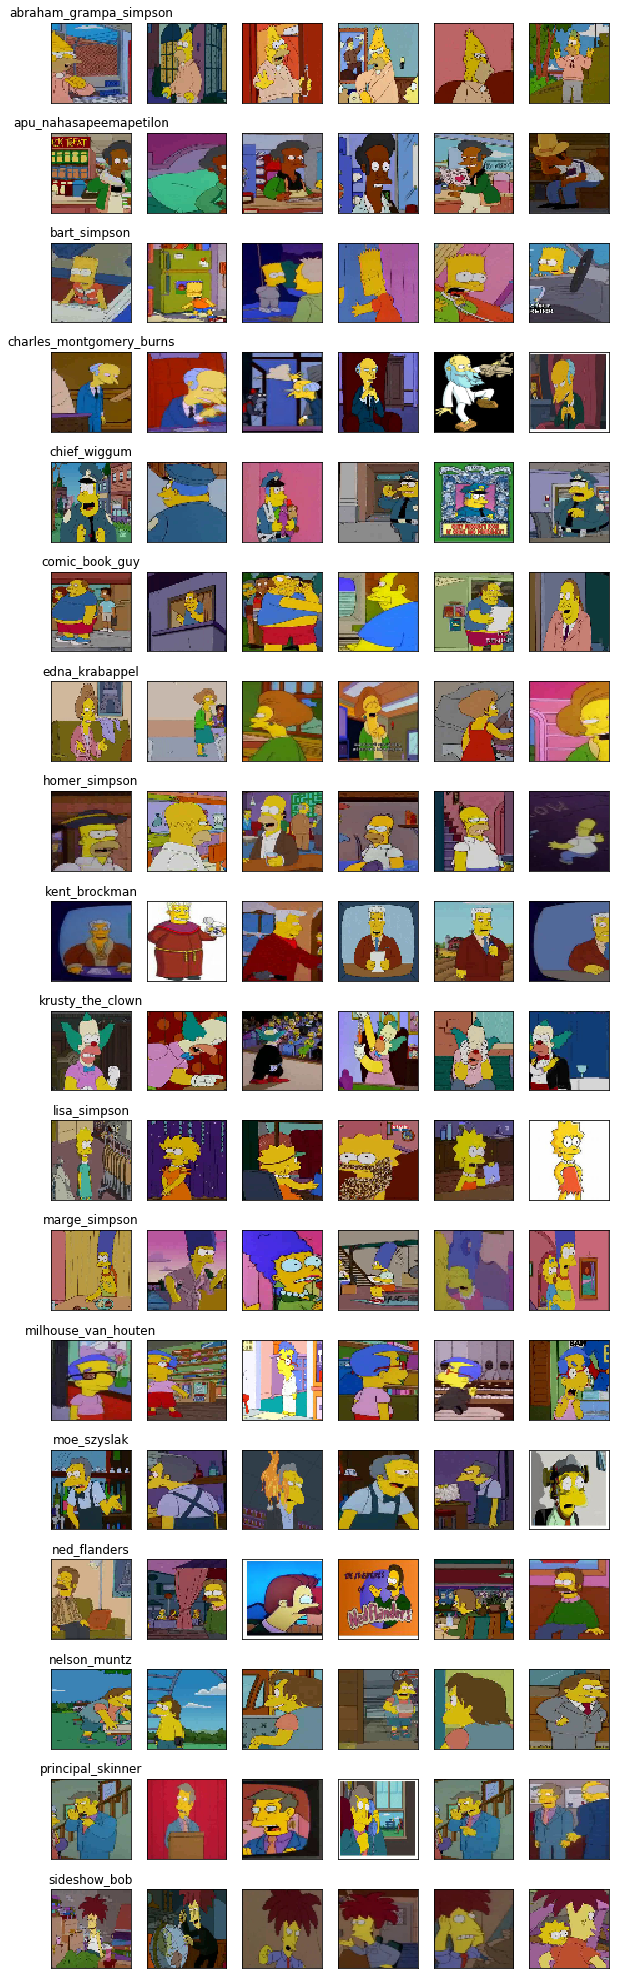

In [5]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
np.random.seed(42)

plt.figure(figsize=(10,36))
for k in range(n_classes):
    n_img=6
    for i in range (1, n_img+1):
        idx = np.random.choice(np.where((np.where(y_train == 1)[1]) == k)[0], size=1)
        plt.subplot(n_classes, n_img, (i) + (k)*n_img)
        plt.imshow(X_train[idx[0]])
        plt.title(map_characters[k] if i==1 else '')
        frame = plt.gca()
        frame.axes.get_xaxis().set_ticks([])
        frame.axes.get_yaxis().set_ticks([])

## Character Classification

Now, it's time to create a classifier for our task. For the classification, we will use a high-level API, called keras. This user friendly library can be used to set up neural networks easily. In the upcoming tutorials, we will also implement this model in TensorFlow. But for the ease of understanding, we will start on a high-level and concentrate on the architecture of the neural network for now.
For more information about Keras, please visit: https://keras.io

#### load dependencies

First, we will load some dependencies, which we will use in the following. 

In [10]:
import numpy as np
np.random.seed(42)
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten, Conv2D, MaxPooling2D
import keras.callbacks
from sklearn.model_selection import train_test_split

#### define hyperparameters

In [11]:
pic_size = 64 # image have size 64x64
c_channels = 3 # color channeld (RGB)

# convolutional layer 1
n_conv_1 = 32
k_size_1 = 3

# convolutional layer 2
n_conv_2 = 64
k_size_2 = 3

# max pool layer
p_size_1 = 2
dropout_1 = .25

# dense layer
n_dense_1 = 128
dropout_2 = .5

#### Design neural network architecture

Now we design our neural network. Therefore, we will use a network consisting of 2 convolutional layers, 1 maxpooling layer and 2 dense layers. 

Architecture:
* 1: Convolutional layer with 32 neurons and a kernel_size of 3 $\times$ 3. The activation function we use is a rectified linear unit (Relu). Also, we define the input shape to be 64 x 64 x 3, as the training images' size is 64x64 with 3 colors channels (RGB)

* 2: Next, we define the second convolutional layer consisting of 64 neurons and also a kernel size of 3 x 3, The activation function is again a rectified linear unit

* 3: The next layer is a max pooling layer with a window of 2 x 2, and we use a dropout of .25

* 4: The next step is to use a dense layer. For that reason we flatten out the images to be in a 1d vector

* 5: We use a dense layer with 128 neurons and ReLu again as the activation function

* 6: For brief of efficiency, we use also a dropout with .5

* 7: The last layer is the output layer. Therefore, we use a dense layer with the number of classes as the number of neurons. The activation function in the last layer is the softmax function

### Tasks
Design the neural network by the described architecture. For a short guide on how to design simple models, one can refer to: https://keras.io/getting-started/sequential-model-guide/ 

In [12]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, BatchNormalization, Dropout
def net():
    model = Sequential()
    model.add(Conv2D(filters=n_conv_1, kernel_size=(k_size_1, k_size_1), activation="relu", input_shape=(pic_size, pic_size, c_channels)))
    model.add(Conv2D(filters=n_conv_2, kernel_size=(k_size_2 ,k_size_2), activation="relu"))
    model.add(MaxPooling2D(pool_size=(p_size_1, p_size_1)))
    model.add(Dropout(dropout_1))
    model.add(Flatten())
    model.add(Dense(units=n_dense_1, activation="relu"))
    model.add(Dropout(dropout_2))
    model.add(Dense(units=n_classes, activation="softmax"))
    return model

Keras provides a method for summarizing the model in terms of the layers and the number of parameters involved in each layer. We get also a summary of the total number of parameters which are learned by the neural network.

In [13]:
# summary of the model
model = net()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 57600)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               7372928   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

#### Configure model

Next, we take care of the configuration of the network. That is to say, we define the loss function being used by the neural net, which optimizer we want to use and how we want to evaluate our model. 
+ Loss function: We use the cross entropy 
+ Optimizer: here we use the ADAM optimizer which is an optimized version of SGD and dynamically adapts the learning rate.
+ For the evaluation of our method we use the accuracy which yields the model, that is to say how accurate our model can predict the class of an unseen image

### Tasks
Configure the model according to the description given above by using the $compile()$ method of keras.

In [14]:
from keras.preprocessing.image import ImageDataGenerator
from keras.losses import categorical_crossentropy
from keras.optimizers import adam, rmsprop
from keras.callbacks import ModelCheckpoint, EarlyStopping

model.compile(loss=categorical_crossentropy,
              optimizer=adam(),
              metrics=['accuracy']
             )
model.summary

<bound method Container.summary of <keras.models.Sequential object at 0x000002CE0043B400>>

#### Train the model!

Finally, we train our model. As input, we use the training dataset, use a batch_size of 128 and train the model for 20 epochs. For validation purpose, we evaluate our model on the test data. By using the keras.callbacks.History(), we can log the performance of our model over the epochs. Another handy thing is, that we can store the weights of our model by using ModelCheckpoint. Hence, we do not have to re-train our model each time and can persist the weights being evaluated from the last time we trained the model.

### Tasks
Train the model by using the $fit()$ method of keras w/ the parameters described above.

...This may take a while. So grab a coffee ...

In [42]:
history = keras.callbacks.History()
checkpoint = keras.callbacks.ModelCheckpoint('weights.hdf5', monitor='val_acc', verbose=0, save_best_only=True, mode='max')

model.fit(X_train, y_train,
          batch_size=128,
          epochs=20,
          verbose=1,
          validation_data=(X_test, y_test),
          callbacks=[history])

Train on 14317 samples, validate on 2527 samples
Epoch 1/20
14317/14317 [==============================] - 273s 19ms/step - loss: 2.6355 - acc: 0.2037 - val_loss: 2.0292 - val_acc: 0.4112
Epoch 2/20
14317/14317 [==============================] - 287s 20ms/step - loss: 1.9951 - acc: 0.3898 - val_loss: 1.5742 - val_acc: 0.5782
Epoch 3/20
14317/14317 [==============================] - 272s 19ms/step - loss: 1.6206 - acc: 0.5050 - val_loss: 1.2689 - val_acc: 0.6474
Epoch 4/20
14317/14317 [==============================] - 276s 19ms/step - loss: 1.3609 - acc: 0.5781 - val_loss: 1.1467 - val_acc: 0.6775
Epoch 5/20
14317/14317 [==============================] - 281s 20ms/step - loss: 1.1477 - acc: 0.6433 - val_loss: 0.9564 - val_acc: 0.7380
Epoch 6/20
14317/14317 [==============================] - 283s 20ms/step - loss: 0.9702 - acc: 0.6880 - val_loss: 0.8737 - val_acc: 0.7657
Epoch 7/20
14317/14317 [==============================] - 279s 19ms/step - loss: 0.8421 - acc: 0.7272 - val_loss: 0.8

Save Keras Model completely

In [43]:
model.save('simpsons_cnn_model.h5')

Save Keras Weights

In [45]:
model.save_weights('simpsons_cnn_model_weights.h5')

Save architecture as JSON

In [55]:
json_string = model.to_json()
print(json_string)

#np
np.save('simpson_cnn_architecture.npy', json_string) 

#JSON
import json
with open('simpson_cnn_architecture.json', 'w') as fp:
    json.dump(json_string, fp)

{"class_name": "Sequential", "config": [{"class_name": "Conv2D", "config": {"name": "conv2d_16", "trainable": true, "batch_input_shape": [null, 64, 64, 3], "dtype": "float32", "filters": 32, "kernel_size": [3, 3], "strides": [1, 1], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"scale": 1.0, "mode": "fan_avg", "distribution": "uniform", "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "Conv2D", "config": {"name": "conv2d_17", "trainable": true, "filters": 64, "kernel_size": [3, 3], "strides": [1, 1], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "VarianceScaling", "con

#### How to restore a model?
Basically, there are three steps to restore a model
+ i) set up the architecture again
+ ii) load stored weights to model
+ iii) configure the model again

In [17]:
import numpy as np
np.random.seed(42)
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten, Conv2D, MaxPooling2D
import keras.callbacks
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, BatchNormalization, Dropout

# set up architecture
model = net()
# load weights
model.load_weights('simpsons_cnn_model_weights.h5')
# configuration
# configuration
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 57600)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               7372928   
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
__________

#### Visualizing learning progress

Visualize the learning progress of your model using its recorded history stored via the keras.callbacks.History(). 

### Tasks 
Prepare 2 plots, where the x-axis shows the number of epochs. For the first plot, the y-axis should correspond to the accuracy, in the second plot, it should indicate the loss. In both plots, add the corresponding learning curves for the training and test set. What do you observe?

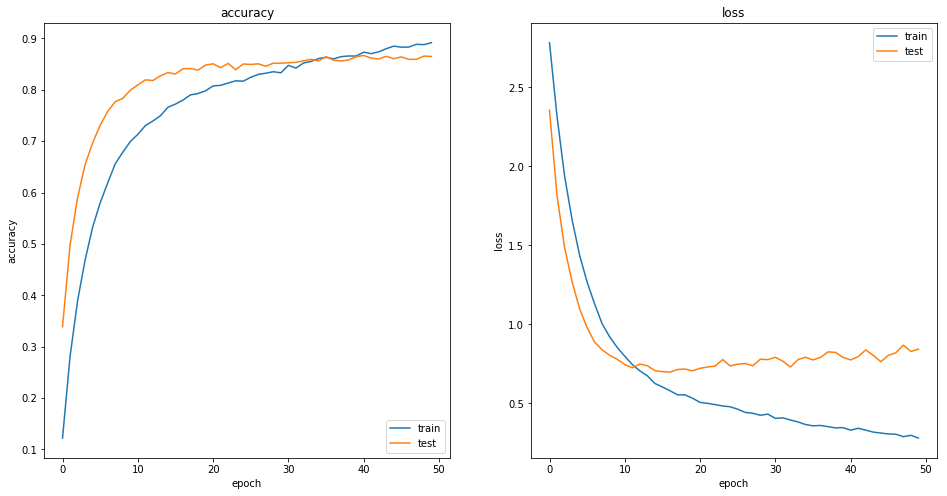

In [20]:
import json
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

with open('training_acc_val.json', 'r') as f:
    history = json.load(f)


fig, axes = plt.subplots(figsize=(16, 8), ncols=2)


# plot accuracy for train and test set
ax = axes[0]
# ax.plot(history.history['acc']) ---> this if want to use history instance
# ax.plot(history.history['val_acc'])
ax.plot(history['acc'])
ax.plot(history['val_acc'])
ax.set_title('accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'test'], loc='lower right')

# plot loss for train and test set
ax = axes[1]
# ax.plot(history.history['loss'])
# ax.plot(history.history['val_loss'])
ax.plot(history['loss'])
ax.plot(history['val_loss'])
ax.set_title('loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'test'], loc='upper right')

# show
plt.show()

# What do we see here?
# - Loss decreses monotonically on the train set; test loss increases towards the end
# - Accuracy keeps increasing -> one could try to train for some more epochs

#### Prediction

We can check the classification metrics in more detail using the classification_report of sklearn (for more details:
http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html ). This yields a text summary of the precision, recall, F1 score for each class.

#### Tasks
Print the report of our classification by using the classification_report provided by sklearn. Note that the first parameter indicates the true values, whereas the second argument indicates the predicted values of our model.

In [21]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
# first arg: true values - second arg: pred. values
print(classification_report(np.where(y_test==1)[1], 
                            np.argmax(y_pred, axis=1), 
                            target_names=list(map_characters.values())))

                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.89      0.74      0.81       145
  apu_nahasapeemapetilon       0.85      0.87      0.86        97
            bart_simpson       0.73      0.81      0.77       161
charles_montgomery_burns       0.77      0.85      0.81       186
            chief_wiggum       0.88      0.89      0.88       151
          comic_book_guy       0.92      0.80      0.86        61
          edna_krabappel       0.88      0.78      0.83        74
           homer_simpson       0.72      0.70      0.71       151
           kent_brockman       0.90      0.96      0.93        72
        krusty_the_clown       0.85      0.93      0.89       177
            lisa_simpson       0.80      0.80      0.80       192
           marge_simpson       0.93      0.92      0.92       164
     milhouse_van_houten       0.93      0.89      0.91       164
             moe_szyslak       0.81      0.84      0.82       191
         

We can also check in more detail, which instances have been misclassified from our trained model. Therefore, we will use a confusion matrix. By definition a confusion matrix $C$ is such that $C_{i, j}$ is equal to the number of observations known to be in group $i$ but predicted to be in group $j$.


#### Tasks
Plot the confusion matrix of our model. We will use the sklearn library for that. For further details on the confusion matrix and its parameters, please refer to:
http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
Note again the the first parameter are the true values, wherease the second parameter indicates the predicted values. For a better understanding, the class-labels (char-names) should be displayed on the axes of our confusion matrix.

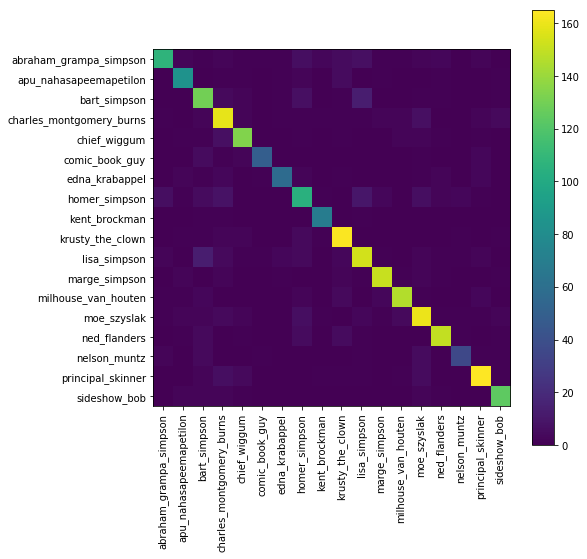

In [22]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(np.where(y_test > 0)[1], np.argmax(y_pred, axis=1))
classes = list(map_characters.values())
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

Now, you are ready to test your own architecture. Feel free to test other architectures and try to improve the accuracy on this dataset. 

# End of this tutorial